## Test Pyro4 Setup

In [2]:
import Pyro4
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.SERIALIZERS_ACCEPTED.add("pickle")
bot = Pyro4.Proxy("PYRONAME:remotelocobot@172.17.0.2")
bot.test_connection()

'Connected!'

In [3]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs)

    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")

    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [4]:
import numpy as np
d3_40_colors_rgb: np.ndarray = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
        [127, 127, 127],
        [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
)

In [5]:
rgb, d, segm = bot.get_rgbd_segm()

In [6]:
def label_prop(postData): 
    
    # Decode rgb map
    rgb_bytes = base64.b64decode(postData["prevRgbImg"])
    rgb_np = np.frombuffer(rgb_bytes, dtype=np.uint8)
    rgb_bgr = cv2.imdecode(rgb_np, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
    src_img = np.array(rgb)
    height, width, _ = src_img.shape

    # Convert depth map to meters
    depth_imgs = []
    for i, depth in enumerate([postData["prevDepth"], postData["depth"]]): 
        depth_encoded = depth["depthImg"]
        depth_bytes = base64.b64decode(depth_encoded)
        depth_np = np.frombuffer(depth_bytes, dtype=np.uint8)
        depth_decoded = cv2.imdecode(depth_np, cv2.IMREAD_COLOR)
        depth_unscaled = (255 - np.copy(depth_decoded[:,:,0]))
        depth_scaled = depth_unscaled / 255 * (float(depth["depthMax"]) - float(depth["depthMin"]))
        depth_imgs.append(depth_scaled)
    src_depth = np.array(depth_imgs[0])
    cur_depth = np.array(depth_imgs[1])

    # Convert mask points to mask maps then combine them
    src_label = np.zeros((height, width)).astype(int)
    for n, o in enumerate(postData["objects"]): 
        poly = Polygons(o["mask"])
        bitmap = poly.mask(height, width)
        for i in range(height): 
            for j in range(width): 
                if bitmap[i][j]: 
                    src_label[i][j] = n + 1

    # Attach base pose data
    pose = postData["prevBasePose"]
    src_pose = np.array([pose["x"], pose["y"], pose["yaw"]])
    pose = postData["basePose"]
    cur_pose = np.array([pose["x"], pose["y"], pose["yaw"]])

    LP = LabelPropagate()
    res_labels = LP(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

    # Convert mask maps to mask points
    objects = {}
    for i_float in np.unique(res_labels): 
        i = int(i_float)
        if i == 0: 
            continue
        objects[i-1] = postData["objects"][i-1] # Do this in the for loop cause some objects aren't returned
        mask_points_nd = Mask(np.where(res_labels == i, 1, 0)).polygons().points
        mask_points = list(map(lambda x: x.tolist(), mask_points_nd))
        objects[i-1]["mask"] = mask_points
        objects[i-1]["type"] = "annotate"

In [9]:
postData = {}
postData["prevRgbImg"] = rgb
postData["prevDepth"] = d
postData["depth"] = d
print(type(d))

<class 'numpy.ndarray'>


In [7]:
import cv2
import os
import base64

rgb = cv2.imread("../../offlineData/rgb/00000.jpg")
print(rgb.shape)

(512, 512, 3)


In [42]:
_, rgb = cv2.imencode('.webp', cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_WEBP_QUALITY), 10])
rgb = base64.b64encode(rgb).decode('utf-8')

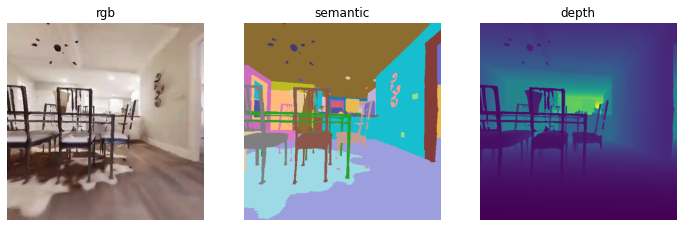

In [43]:
rgb_bytes = base64.b64decode(rgb)
rgb_np = np.frombuffer(rgb_bytes, dtype=np.uint8)
rgb_bgr = cv2.imdecode(rgb_np, cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
src_img = np.array(rgb_bgr)
display_sample(src_img, segm, d)

In [8]:
src_img = np.load("../../rgb.jpg.npy")
src_depth = np.load('../../src_depth.npy')
cur_depth = np.load('../../cur_depth.npy')
src_pose = np.load("../../src_pose.npy")
cur_pose = np.load("../../cur_pose.npy")
src_label = np.load("../../src_label.npy")
res_labels = np.load("../../res_labels.npy")
osi = np.load("../../osi.npy")
osd = np.load("../../osd.npy")
ocd = np.load("../../ocd.npy")
osp = np.load("../../osp.npy")
ocp = np.load("../../ocp.npy")
osl = np.load("../../osl.npy")
orl = np.load("../../or.npy")

In [9]:
print(type(src_img), src_img.shape)
print(type(osi), osi.shape)
print(type(src_depth), src_depth.shape)
print(type(osd), osd.shape)
print(type(cur_depth), cur_depth.shape)
print(type(ocd), ocd.shape)
print(type(src_label), src_label.shape)
print(type(osl), osl.shape)
print(type(src_pose), src_pose)
print(type(osp), osp)
print(type(cur_pose), cur_pose)
print(type(ocp), ocp)

<class 'numpy.ndarray'> (512, 512, 3)
<class 'numpy.ndarray'> (512, 512, 3)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> [-4.47034836e-08  0.00000000e+00  3.00000137e-01]
<class 'numpy.ndarray'> [-0.         -0.          0.01047194]
<class 'numpy.ndarray'> [-4.47034836e-08  0.00000000e+00  1.78813920e-07]
<class 'numpy.ndarray'> [-0.         -0.          0.02617986]


In [10]:
print(np.unique(src_label, return_counts=True))
print(np.unique(osl, return_counts=True))

(array([0, 1, 2]), array([256845,   2308,   2991]))
(array([0, 1]), array([260094,   2050]))


In [11]:
print(np.average(src_img))
print(np.average(osi))
print(np.average(src_depth))
print(np.average(osd))

147.79170608520508
144.23125712076822
2228.004181985294
2221.72359085083


In [12]:
print(np.mean(src_depth))
print(np.mean(osd))
print(np.std(src_depth))
print(np.std(osd))

2228.004181985294
2221.72359085083
1417.4476706304918
1430.0137636558284


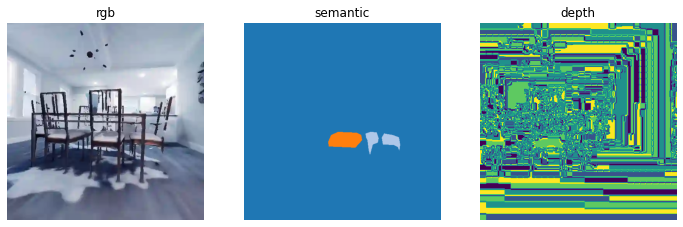

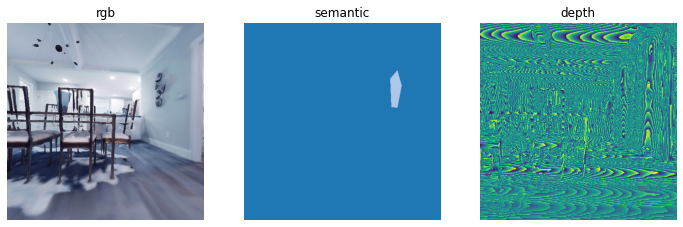

In [13]:
display_sample(src_img, src_label, src_depth)
display_sample(osi, osl, osd)

In [14]:
print(np.unique(res_labels, return_counts=True))
print(np.unique(orl, return_counts=True))

(array([0., 1., 2.]), array([261017,    189,    938]))
(array([0., 1.]), array([259947,   2197]))


In [37]:
# Depth testing
d = np.load("../../og_depth.npy")
minmax = np.load('../../depth_min_max.npy')
dd = np.load("../../ogogdepth.npy")
print(str(d)[:100])
print(dd)
print(np.std(dd))
print(np.average(dd))
print(minmax)

UklGRj4LAABXRUJQVlA4IDILAADwkwCdASoAAgACP3G21WQ0rj+yIdF5Q/AuCWlu4WYxG/Npn2dcpYjtz/oPDM83OH75vU18df7d
[[1959. 1959. 1958. ... 1557. 1551. 1546.]
 [1967. 1967. 1966. ... 1557. 1551. 1546.]
 [1975. 1975. 1975. ... 1557. 1551. 1546.]
 ...
 [ 643.  644.  644. ...  674.  674.  674.]
 [ 641.  641.  641. ...  671.  671.  672.]
 [ 639.  639.  639. ...  669.  669.  669.]]
1433.9453
2229.5303
[ 639. 9855.]


In [23]:
depth_bytes = base64.b64decode(d)
depth_np = np.frombuffer(depth_bytes, dtype=np.uint8)
print(np.unique(depth_np, return_counts=True))
depth_decoded = cv2.imdecode(depth_np, cv2.IMREAD_COLOR)
depth_unscaled = (255 - np.copy(depth_decoded[:,:,0]))
depth_scaled = depth_unscaled / 255 * (float(minmax[0]) - float(minmax[0]))
final_depth = depth_scaled + float(minmax[0])
print(final_depth)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

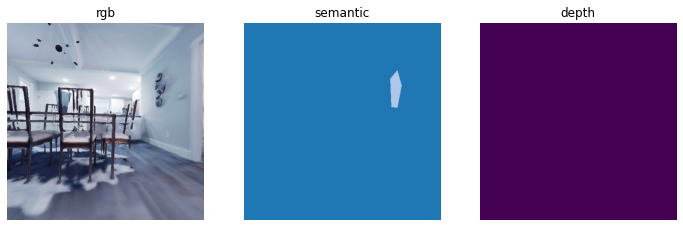

In [38]:
display_sample(osi, osl, final_depth)

In [48]:
dr = cv2.resize(dd, (512,512), interpolation=cv2.INTER_LINEAR)
dn = cv2.normalize(dr, None, 0, 255, cv2.NORM_MINMAX)
dn = 255 - dn
_, depth_img_data = cv2.imencode('.webp', dn, [int(cv2.IMWRITE_WEBP_QUALITY), 10])

print(dn)
print(depth_img_data)

[[218.47656 218.47656 218.50423 ... 229.59961 229.76562 229.90398]
 [218.2552  218.2552  218.28287 ... 229.59961 229.76562 229.90398]
 [218.03384 218.03384 218.03384 ... 229.59961 229.76562 229.90398]
 ...
 [254.88933 254.86165 254.86165 ... 254.03157 254.03157 254.03157]
 [254.94466 254.94466 254.94466 ... 254.11458 254.11458 254.08691]
 [255.      255.      255.      ... 254.16992 254.16992 254.16992]]
[[82]
 [73]
 [70]
 ...
 [ 0]
 [ 0]
 [ 0]]


In [57]:
a = np.load("../../annotation_data/depth/cur_depth.npy")
depth_bytes = base64.b64decode(a)
depth_np = np.frombuffer(depth_bytes, dtype=np.uint64)
depth_decoded = depth_np.reshape((512, 512))
print(depth_decoded)

[[1852 1851 1849 ... 1864 1861 1858]
 [1853 1851 1850 ... 1869 1866 1863]
 [1854 1853 1853 ... 1874 1871 1868]
 ...
 [ 643  644  644 ...  673  673  673]
 [ 641  641  641 ...  670  670  670]
 [ 639  639  639 ...  667  667  668]]
